In [1]:
import math
import numpy as np
from deap import base
from deap import creator
from deap import tools

import random

import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append('../marine/pipelay_vessel_design_optimisation_using_genetic_algorithms/')

In [3]:
import elitism

### Finite Element Model of the Plane Truss structure

In [4]:
def PlaneTrussElementLength(x1,y1,x2,y2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1))

In [5]:
def PlaneTrussElementStiffness(E,A,L,theta):
    pi=3.14159265
    x = theta*pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.array([[C*C, C*S, -C*C, -C*S],[C*S, S*S, -C*S, -S*S],
                           [-C*C, -C*S, C*C, C*S],[-C*S, -S*S, C*S, S*S]]) 

In [6]:
def PlaneTrussAssemble(K,k,i,j):
    # K - np.array
    # k - np.array
    K[2*i,2*i] = K[2*i,2*i] + k[0,0]
    K[2*i,2*i+1] = K[2*i,2*i+1] + k[0,1] 
    K[2*i,2*j] = K[2*i,2*j] + k[0,2] 
    K[2*i,2*j+1] = K[2*i,2*j+1] + k[0,3]
    K[2*i+1,2*i] = K[2*i+1,2*i] + k[1,0]
    K[2*i+1,2*i+1] = K[2*i+1,2*i+1] + k[1,1] 
    K[2*i+1,2*j] = K[2*i+1,2*j] + k[1,2] 
    K[2*i+1,2*j+1] = K[2*i+1,2*j+1] + k[1,3] 
    K[2*j,2*i] = K[2*j,2*i] + k[2,0] 
    K[2*j,2*i+1] = K[2*j,2*i+1] + k[2,1]
    K[2*j,2*j] = K[2*j,2*j] + k[2,2]
    K[2*j,2*j+1] = K[2*j,2*j+1] + k[2,3] 
    K[2*j+1,2*i] = K[2*j+1,2*i] + k[3,0] 
    K[2*j+1,2*i+1] = K[2*j+1,2*i+1] + k[3,1]
    K[2*j+1,2*j] = K[2*j+1,2*j] + k[3,2] 
    K[2*j+1,2*j+1] = K[2*j+1,2*j+1] + k[3,3]
    
    return K 

In [7]:
def PlaneTrussElementForce(E,A,L,theta,u):
    pi=3.14159265
    x = theta* pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E*A/L*np.dot(np.array([-C, -S, C, S]),u)

In [8]:
def PlaneTrussElementStress(E,L,theta,u):
    pi=3.14159265
    x = theta * pi/180
    C = math.cos(x)
    S = math.sin(x)
    return E/L*np.dot(np.array([-C, -S, C, S]),u)

In [9]:
def FEA_u(coord, elcon, bc_u_elim, f_after_u_elim, A=1, E=2e5):
    K=np.zeros(shape=(2*np.max(elcon)+2,2*np.max(elcon)+2))
    pi=3.14159265
    for el in elcon:
        L=PlaneTrussElementLength(coord[el[0]][0],coord[el[0]][1],coord[el[1]][0],coord[el[1]][1])
        theta=math.atan((coord[el[1]][1]-coord[el[0]][1])/(coord[el[1]][0]-coord[el[0]][0]+1e-13))*180/pi
        k=PlaneTrussElementStiffness(E,A,L,theta)
        K=PlaneTrussAssemble(K,k,el[0],el[1])
    K=np.delete(K,bc_u_elim,0)
    K=np.delete(K,bc_u_elim,1)
    
    
    d=np.dot(np.linalg.inv(K),f_after_u_elim)

        
    u=np.zeros(shape=(2*len(coord)))

    j=0
    for i in range(len(u)):
        if i not in bc_u_elim:
            u[i]=d[j]
            j+=1
            if j>len(d)-1:
                break
    return u

### Initial displacement 

In [10]:
coord=np.array([0.0,0.0,
                  2.0,3.0,
                  2.0,0.0,
                  5.0,3.0,
                  7.0,0.0,
                  9.0,3.0,
                  12.0,3.0,
                  12.0,0.0,
                  14.0,0.0]).reshape(9,2)

In [11]:
displ = FEA_u(coord.reshape(9,2), 
              elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                             [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                             [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                             bc_u_elim=[0,1,16,17],
                             f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                             A=1, E=2e5)

In [12]:
displ[9]

-0.0008888028010760273

### Genetic Algorithm

In [13]:
BOUNDS_LOW =  [0, 0, 2, 5, 5, 5]
BOUNDS_HIGH = [5, 5, 9, 12, 14, 14]

In [14]:
NUM_OF_PARAMS = len(BOUNDS_HIGH)

In [15]:
# Genetic Algorithm constants:
POPULATION_SIZE = 250
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.5   # probability for mutating an individual
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 5
CROWDING_FACTOR = 20.0  # crowding factor for crossover and mutation

PENALTY_VALUE = 10.0    # fixed penalty for violating a constraint

# set the random seed:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

toolbox = base.Toolbox()

In [16]:
# define a single objective, maximize fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)


# define the hyperparameter attributes individually:
for i in range(NUM_OF_PARAMS):
    # "hyperparameter_0", "hyperparameter_1", ...
    toolbox.register("hyperparameter_" + str(i),
                     random.uniform,
                     BOUNDS_LOW[i],
                     BOUNDS_HIGH[i])

In [17]:
# create a tuple containing an attribute generator for each param searched:
hyperparameters = ()

for i in range(NUM_OF_PARAMS):
    hyperparameters = hyperparameters + (toolbox.__getattribute__("hyperparameter_" + str(i)),)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator",
                 tools.initCycle,
                 creator.Individual,
                 hyperparameters,
                 n=1)

In [18]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

In [19]:
# fitness calculation
def femStatic(individual):
    x1=individual[0]
    x2=individual[1]
    x3=individual[2]
    x5=individual[3]
    x6=individual[4]
    x7=individual[5]
    
    coord=np.array([0.0,0.0,
                  x1,3.0,
                  x2,0.0,
                  x3,3.0,
                  7.0,0.0,
                  x5,3.0,
                  x6,3.0,
                  x7,0.0,
                  14.0,0.0]).reshape(9,2)
    
    displ = FEA_u(coord, 
              elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                             [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                             [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                             bc_u_elim=[0,1,16,17],
                             f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                             A=1, E=2e5)
    return displ[9],

In [20]:
toolbox.register("evaluate", femStatic)

# genetic operators:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate",
                 tools.cxSimulatedBinaryBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR)

toolbox.register("mutate",
                 tools.mutPolynomialBounded,
                 low=BOUNDS_LOW,
                 up=BOUNDS_HIGH,
                 eta=CROWDING_FACTOR,
                 indpb=1.0 / NUM_OF_PARAMS)


In [21]:
# Genetic Algorithm flow:
def main():

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = elitism.eaSimpleWithElitism(population,
                                                      toolbox,
                                                      cxpb=P_CROSSOVER,
                                                      mutpb=P_MUTATION,
                                                      ngen=MAX_GENERATIONS,
                                                      stats=stats,
                                                      halloffame=hof,
                                                      verbose=True)


    # print info for best solution found:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    print()
    print("Double check: ")
    
    
    x1 = best[0]  
    x2 = best[1]  
    x3 = best[2]  
    x5 = best[3]  
    x6 = best[4]  
    x7 = best[5] 
    
    g_coord=np.array([0.0,0.0,
                  x1,3.0,
                  x2,0.0,
                  x3,3.0,
                  7.0,0.0,
                  x5,3.0,
                  x6,3.0,
                  x7,0.0,
                  14.0,0.0]).reshape(9,2)
    


    displ = FEA_u(g_coord, elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                             [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                             [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]),
                             bc_u_elim=[0,1,16,17],
                             f_after_u_elim=np.array([0,0,0,0,0,0,0,-10,0,0,0,0,0,0]), 
                             A=1, E=2e5)


    print("displ", displ[9], )
    
    # extract statistics:
    maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

    # plot statistics:
    sns.set_style("whitegrid")
    plt.plot(maxFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max/ Average Fitness')
    plt.title('Max and Average fitness over Generations')
    plt.savefig("gen.png")
    plt.show()
    return g_coord

gen	nevals	max         	avg        
0  	250   	-0.000895096	-0.00170254
1  	232   	-0.000892618	-0.00142935
2  	228   	-0.000882098	-0.00124052
3  	233   	-0.000850062	-0.00113006
4  	231   	-0.000847364	-0.00103603
5  	232   	-0.00084187 	-0.000970155
6  	235   	-0.000839096	-0.00093097 
7  	228   	-0.000832463	-0.000904476
8  	232   	-0.000830074	-0.000885407
9  	233   	-0.000828387	-0.000872556
10 	235   	-0.000822803	-0.000857107
11 	234   	-0.000822086	-0.000849132
12 	229   	-0.000821482	-0.000841828
13 	234   	-0.000820416	-0.000836234
14 	237   	-0.000820072	-0.000831792
15 	236   	-0.000819905	-0.000830284
16 	234   	-0.000819498	-0.000828245
17 	225   	-0.000819498	-0.000826122
18 	234   	-0.000819498	-0.000826634
19 	228   	-0.000819498	-0.000825306
20 	228   	-0.000819498	-0.00082418 
21 	232   	-0.000819421	-0.000823251
22 	225   	-0.000819421	-0.000823019
23 	232   	-0.000819338	-0.000823358
24 	230   	-0.000819245	-0.000822763
25 	234   	-0.000819245	-0.000823372
26 	223

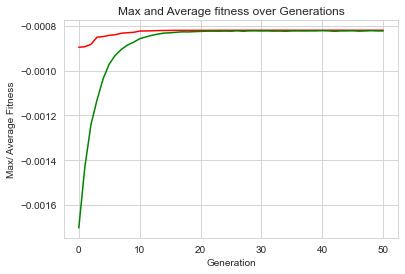

In [22]:
g_coord=main()

In [23]:
def draw(coord,color,elcon):
    coord=coord.reshape(np.max(elcon)+1,2)
    plt.figure(figsize=(13,5))
    for item in elcon:
        plt.plot([coord[item[0]][0],coord[item[1]][0]],
                 [coord[item[0]][1],coord[item[1]][1]],color=color)
        
    plt.show() 

### Initial Design 

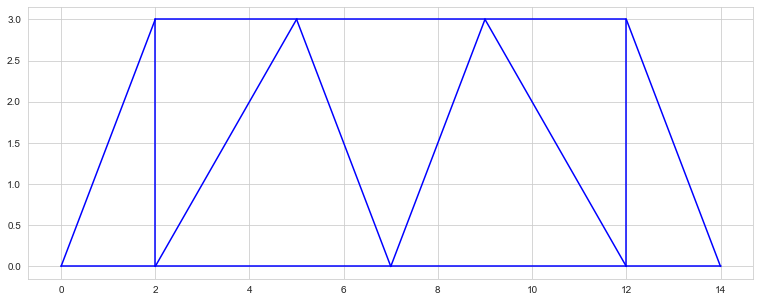

In [24]:
draw(coord,color="blue",elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))

### Final Design

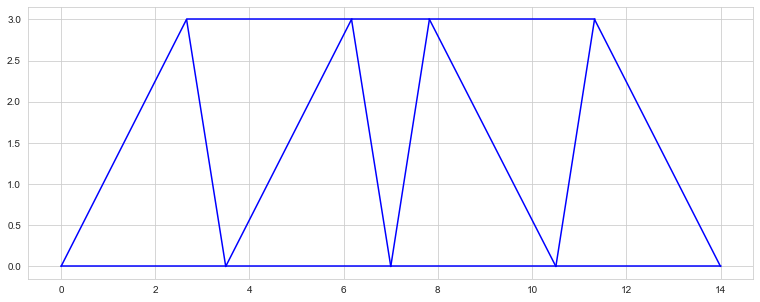

In [25]:
draw(g_coord,color="blue",elcon=np.array([[0, 1],[0, 2],[1, 2],[1, 3],[2, 3],
                                                    [2, 4],[3, 4],[3, 5],[4, 5],[4, 7],
                                                    [5, 7],[5, 6],[6, 7],[6, 8],[7, 8]]))

In [26]:
g_coord

array([[ 0.        ,  0.        ],
       [ 2.66448712,  3.        ],
       [ 3.49575224,  0.        ],
       [ 6.16677986,  3.        ],
       [ 7.        ,  0.        ],
       [ 7.82024137,  3.        ],
       [11.32561298,  3.        ],
       [10.50503106,  0.        ],
       [14.        ,  0.        ]])